In [1]:
!pip install tqdm

^C


In [14]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   --- ------------------------------------ 1.0/11.0 MB 3.1 MB/s eta 0:00:04
   ------- -------------------------------- 2.1/11.0 MB 3.8 MB/s eta 0:00:03
   ----------- ---------------------------- 3.1/11.0 MB 4.1 MB/s eta 0:00:02
   ---------------- ----------------------- 4.5/11.0 MB 4.6 MB/s eta 0:00:02
   --------------------- ------------------ 6.0/11.0 MB 5.1 MB/s eta 0:00:01
   ---------------------------- ----------- 7.9/11.0 MB 5.6 MB/s eta 0:00:01
   ------------------------------------ --- 10.0/11.0 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------- 11.0/11.0 MB 6.4 MB/s eta 0:00:00

   ---------------------------------------- 0/4 [pytz]
   ---------------------------------------- 0/4 [pytz]
   ---------

In [47]:
!pip install fitter

In [2]:
import qutip
import numpy as np
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from tqdm import tqdm
from qutip import Qobj, tensor, qeye, sigmax, sigmay, sigmaz, expect, basis
from qutip import *
import warnings
import os
from fitter import Fitter
import scipy.stats as stats
warnings.filterwarnings("ignore", category=RuntimeWarning)

print("qutip version:", qutip.__version__)

print("All packages imported successfully!")
qutip.about()

qutip version: 5.2.0
All packages imported successfully!

QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.2.0
Numpy Version:      1.26.4
Scipy Version:      1.15.2
Cython Version:     None
Matplotlib Version: 3.10.3
Python Version:     3.12.9
Number of CPUs:     16
BLAS Info:          Generic
INTEL MKL Ext:      None
Platform Info:      Windows (AMD64)
Installation path:  c:\Users\Ahmed Aman\cwq\miniconda3\envs\DFEnum-env\Lib\site-packages\qutip

Installed QuTiP family packages
-----

## To Get the User input variables

In [45]:
# Constants
n_qubits = 4
dim = 2 ** n_qubits
epsilon = 0.05
delta = 0.05
ell = int(np.ceil(1 / (epsilon**2 * delta)))  # Number of Pauli samples

# User input

#To select noise types
noise_type = input("Enter noise type (depolarizing[1] / phase[2] / amplitude[3]) / generalized_amp[4]) : ").strip().lower()
# with 5% probability of flipping the result
p_flip = 0.05

p_absorption = 0.0 # Default value, only used for GAD noise

if noise_type == '4':
    p_absorption = float(input("Enter the thermal absorption probability 'p' (e.g., 0.1): ").strip())

#To select state type
state_types = ['haar[1]', 'w[2]', 'ghz[3]']
state = input(f"Choose state type {state_types}: ").strip().lower()

print("Number of Pauli samples (ell):", ell)

# Define single-qubit Pauli matrices
def get_pauli(char):
    if char == 'I': return qeye(2)
    elif char == 'X': return sigmax()
    elif char == 'Y': return sigmay()
    elif char == 'Z': return sigmaz()

# Convert Pauli string to qutip tensor operator
def pauli_str_to_qobj(p_str):
    return tensor([get_pauli(p) for p in p_str])

# Precompute n-qubit identity operator
identity_n = tensor([qeye(2) for _ in range(n_qubits)])

# Generate all n-qubit Pauli strings
pauli_strings = list(itertools.product(['I', 'X', 'Y', 'Z'], repeat=n_qubits))

print("Generating Pauli operators...")
pauli_ops = [pauli_str_to_qobj(p) for p in tqdm(pauli_strings)]

# Run the defined functions

def haar_random_qobj(n):
    dim = 2**n_qubits
    psi = np.random.randn(dim) + 1j * np.random.randn(dim)
    psi /= np.linalg.norm(psi)
    return Qobj(psi, dims=[[2]*n, [1]*n])

def w_state_qobj(n):
    from qutip import Qobj
    dim = 2 ** n
    w = np.zeros(dim, dtype=complex)
    for i in range(n):
        idx = 1 << (n - i - 1)
        w[idx] = 1
    w /= np.sqrt(n)
    return Qobj(w, dims=[[2]*n, [1]*n])

def ghz_state_qobj(n):
    from qutip import Qobj
    zero = tensor([basis(2, 0) for _ in range(n)])
    one  = tensor([basis(2, 1) for _ in range(n)])
    ghz = (zero + one).unit()
    return ghz  # already a ket

def generate_state():

    if state == '1':
        return haar_random_qobj(n_qubits)
    elif state == '2':
        return w_state_qobj(n_qubits)
    elif state == '3':
        return ghz_state_qobj(n_qubits)
    else:
        raise ValueError(f"Invalid state type: {state}")

def apply_local_noise(rho, kraus_ops, qubit_index, n_qubits):
    result = 0
    for E in kraus_ops:
        ops = [qeye(2)] * n_qubits
        ops[qubit_index] = E
        K = tensor(ops)
        result += K * rho * K.dag()
    return result

def apply_noise(rho, noise_type, gamma, p):
    """
    Apply a noise channel to the input density matrix based on user-specified type.

    Parameters:
        rho (Qobj): Density matrix.
        noise_type (str): One of 'depolarizing', 'phase', or 'amplitude'.
        gamma (float): Noise strength/probability (0 <= gamma <= 1).

    Returns:
        Qobj: Noisy density matrix.
    """
    n_qubits = int(np.log2(rho.shape[0]))
    dim = rho.shape[0]

    if noise_type == '1':
        identity_n = identity([2]*n_qubits)
        return (1 - gamma) * rho + (gamma / dim) * identity_n

    elif noise_type == '2':
        E0 = Qobj([[1, 0], [0, np.sqrt(1 - gamma)]])
        E1 = Qobj([[0, 0], [0, np.sqrt(gamma)]])
        kraus_ops = [E0, E1]

    elif noise_type == '3':
        E0 = Qobj([[1, 0], [0, np.sqrt(1 - gamma)]])
        E1 = Qobj([[0, np.sqrt(gamma)], [0, 0]])
        kraus_ops = [E0, E1]

    elif noise_type == '4':
        E0 = np.sqrt(p) * Qobj([[1, 0], [0, np.sqrt(1 - gamma)]])
        E1 = np.sqrt(p) * Qobj([[0, np.sqrt(gamma)], [0, 0]])
        E2 = np.sqrt(1 - p) * Qobj([[np.sqrt(1 - gamma), 0], [0, 1]])
        E3 = np.sqrt(1 - p) * Qobj([[0, 0], [np.sqrt(gamma), 0]])

        kraus_ops = [E0, E1, E2, E3]

    else:
        raise ValueError("Invalid noise_type. Choose 'depolarizing', 'phase', or 'amplitude'.")

    for i in range(n_qubits):
        rho = apply_local_noise(rho, kraus_ops, i, n_qubits)

    return rho


def measure_with_noise_vectorized(op, state, n_shots, confusion_matrix, dim):
    """
    Vectorized simulation of measurements with noise so that we can handle large n_shots efficiently, rather than looping through each shot.
    """
    # Calculate the probability of measuring +1 without noise
    exp_val = expect(op, state)
    p_plus = np.clip((1 + exp_val.real) / 2, 0, 1)

    # 1. Simulate the total number of "true" +1 outcomes in one go
    num_true_plus_1 = np.random.binomial(n_shots, p_plus)
    num_true_minus_1 = n_shots - num_true_plus_1

    # Probabilities from the confusion matrix M[i, j] = P(report j | true i)
    # Note: We assume the first column is for outcome '+1'
    p_report_plus1_given_true_plus1 = confusion_matrix[0, 0]
    p_report_plus1_given_true_minus1 = confusion_matrix[1, 0]

    # 2. Simulate how many of each "true" group get reported as +1
    reported_plus1_from_true_plus1 = np.random.binomial(num_true_plus_1, p_report_plus1_given_true_plus1)
    reported_plus1_from_true_minus1 = np.random.binomial(num_true_minus_1, p_report_plus1_given_true_minus1)

    # 3. Calculate the total outcomes and the mean
    total_reported_plus_1 = reported_plus1_from_true_plus1 + reported_plus1_from_true_minus1
    total_reported_minus_1 = n_shots - total_reported_plus_1

    # The mean is (num_+1 * 1 + num_-1 * -1) / n_shots
    mean_outcomes = (total_reported_plus_1 - total_reported_minus_1) / n_shots

    return mean_outcomes / np.sqrt(dim)

def run_simulation_optimized(gamma, p_flip, num_trials):
    """
    The simulation using the much faster vectorized measurement function.
    """
    
    # confusion matrix for measurement errors
    M = np.array([[1 - p_flip, p_flip], [p_flip, 1 - p_flip]])
    correction_factor = 1 - 2 * p_flip

    psi = generate_state()
    rho = psi * psi.dag()

    chi_rho_all = np.array([expect(W, psi).real for W in pauli_ops]) / np.sqrt(dim)
    probs = chi_rho_all**2
    probs /= probs.sum()

    all_residuals = []
    all_total_copies = []
    all_fidelity_ests = []
    all_true_fidelities = []

    for _ in range(num_trials):
        sigma = apply_noise(rho, noise_type=noise_type, gamma=gamma, p=p_absorption)
        
        sampled_indices = np.random.choice(len(pauli_ops), size=ell, p=probs)
        
        tilde_X = []

        m_total = 0

        for i in range(ell):
            k = sampled_indices[i]
            chi_rho_k = chi_rho_all[k]
            
            if abs(chi_rho_k) < 1e-9: continue
            
            W_k = pauli_ops[k]
            m_i = int(np.ceil((2 / (dim * chi_rho_k**2 * ell * epsilon**2)) * np.log(2 / delta)))

            m_total += m_i
        
            chi_sigma_ests = measure_with_noise_vectorized(W_k, sigma, m_i, M, dim)
            
            X_i = (chi_sigma_ests / chi_rho_k) / correction_factor
            tilde_X.append(X_i)

        if not tilde_X: continue

        Y_tilde = np.mean(tilde_X)
        all_fidelity_ests.append(Y_tilde)

        #true_fidelity = np.ceil(expect(sigma, psi).real * 10 ** 5)/10 ** 5
        true_fidelity = expect(sigma, psi).real
        all_true_fidelities.append(true_fidelity)

        residual = (Y_tilde - true_fidelity)
        all_residuals.append(residual)
        all_total_copies.append(m_total)
            
    return all_residuals , all_fidelity_ests , all_true_fidelities , all_total_copies


if noise_type == '1':
    noise_type_str = 'Depolarizing'
elif noise_type == '2':
    noise_type_str = 'Phase'
elif noise_type == '3':
    noise_type_str = 'Amplitude'
elif noise_type == '4':
    noise_type_str = 'Generalized Amplitude'

if state == '1':
    state_str = 'Haar'
elif state == '2':
    state_str = 'W'
elif state == '3':
    state_str = 'GHZ'

Number of Pauli samples (ell): 8000
Generating Pauli operators...


100%|██████████| 256/256 [00:00<00:00, 17067.36it/s]


## Run the simulation

In [46]:
residuals, all_fidelity_ests, all_true_fidelities, all_total_copies = run_simulation_optimized(gamma=0.1, p_flip=0, num_trials=1000)

## Finding the best possible fit for the 1000 trial distribution.

Finding the best probability distribution for your data...

Best fitting distribution found: 'skewnorm'
------------------------------------------------------------
Generating 9,000 new samples using the fitted distribution...
New samples generated and constraints applied.
------------------------------------------------------------
Total data points: 10000
Original points: 1000
Newly generated points: 9000


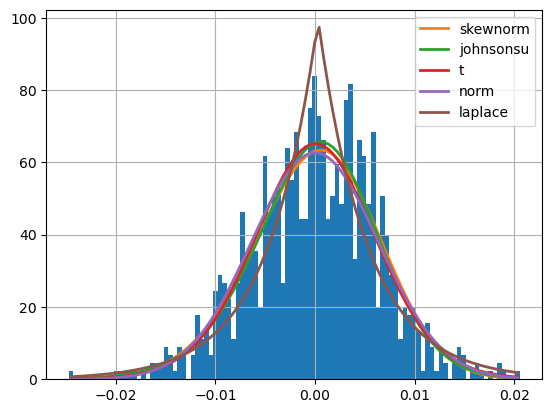

In [47]:
# -----------------------------------------------------
# APPLYING MONTE CARLO SAMPLING BY FINDING THE BEST FIT
# -----------------------------------------------------

# Step 1: Find the best-fitting distribution.

print("Finding the best probability distribution for your data...")

# Define a set of candidate distributions
candidate_distributions = ['norm', 't', 'laplace', 'skewnorm', 'johnsonsu']

# Use Fitter to find the best model for your 500 data points
f_1 = Fitter(residuals, distributions=candidate_distributions)
f_1.fit()

f_2 = Fitter(all_fidelity_ests, distributions=candidate_distributions)
f_2.fit()

summary_df = f_1.summary()

# Get the name and parameters of the best-fitting distribution

# For Residual Distribution
best_fit_1 = f_1.get_best()
best_dist_name_1 = list(best_fit_1.keys())[0]
best_dist_params_1 = best_fit_1[best_dist_name_1]

# For Fidelity Estimation Distribution
best_fit_2 = f_2.get_best()
best_dist_name_2 = list(best_fit_2.keys())[0]
best_dist_params_2 = best_fit_2[best_dist_name_2]

print(f"\nBest fitting distribution found: '{best_dist_name_1}'")
print("-" * 60)

# Step 2: Generate 9,000 new samples from the fitted distribution.

print("Generating 9,000 new samples using the fitted distribution...")

# Get the distribution object from scipy.stats
dist_1 = getattr(stats, best_dist_name_1)
dist_2 = getattr(stats, best_dist_name_2)

# Generate 9,000 new random values using the fitted parameters
# The ** operator unpacks the parameter dictionary
new_residuals = dist_1.rvs(size=9000, **best_dist_params_1)

new_fidelity_ests = dist_2.rvs(size=9000, **best_dist_params_2)

print("New samples generated and constraints applied.")
print("-" * 60)

# Step 3: Combine original data and new data.

# Concatenate your original 1000 points with the new 9000 points
final_residuals = np.concatenate((residuals, new_residuals))
final_fidelity_ests = np.concatenate((all_fidelity_ests, new_fidelity_ests))

print(f"Total data points: {len(final_residuals)}")
print(f"Original points: {len(residuals)}")
print(f"Newly generated points: {len(new_residuals)}")

## To print the outputs 


state=GHZ, n=4 qubits, ε=0.05, δ=0.05, noise type=Generalized Amplitude 10%

----------------------------------------------------
Plotting the Residual errors (Y - F) side-by-side...
----------------------------------------------------


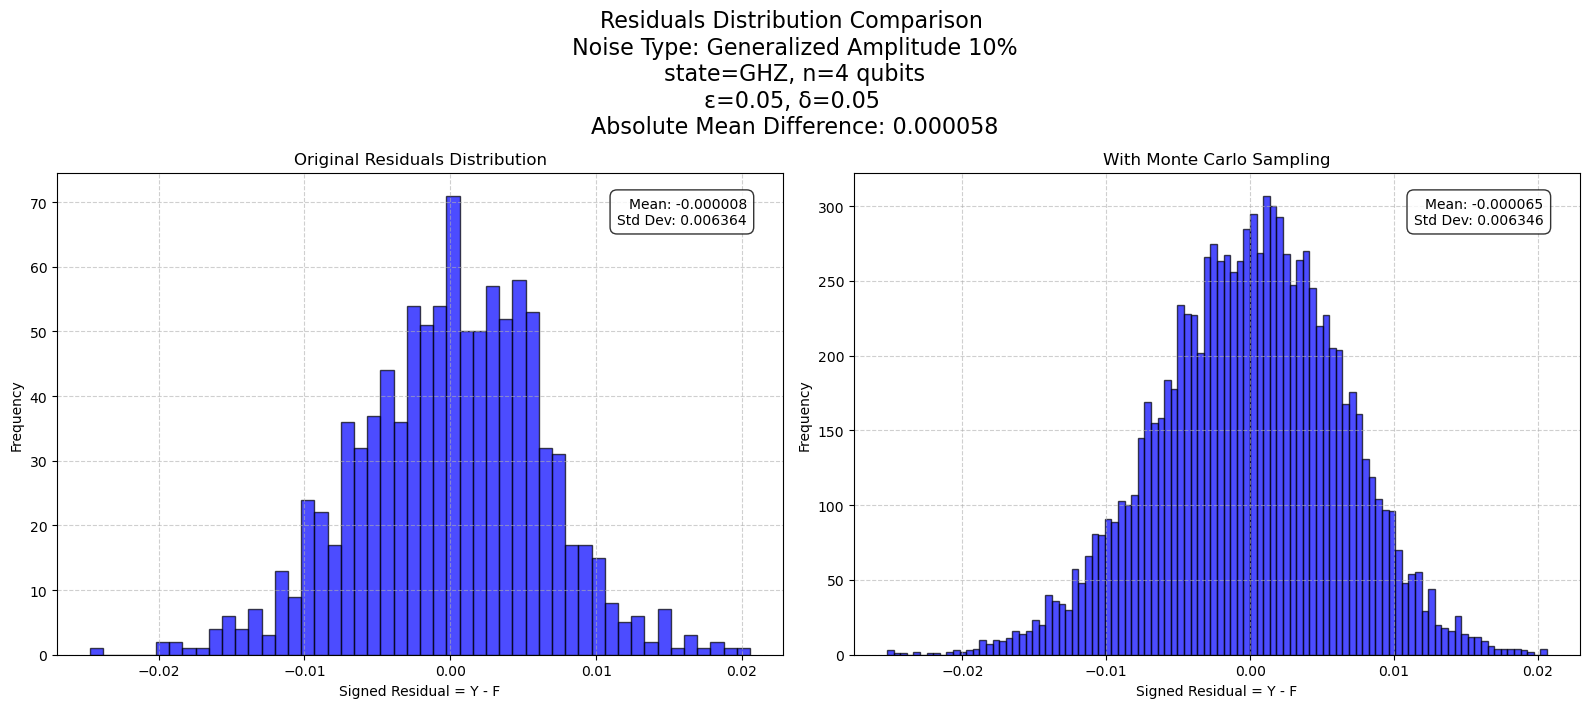


-----------------------------------------------
Plotting the Fidelity Estimates side-by-side...
-----------------------------------------------


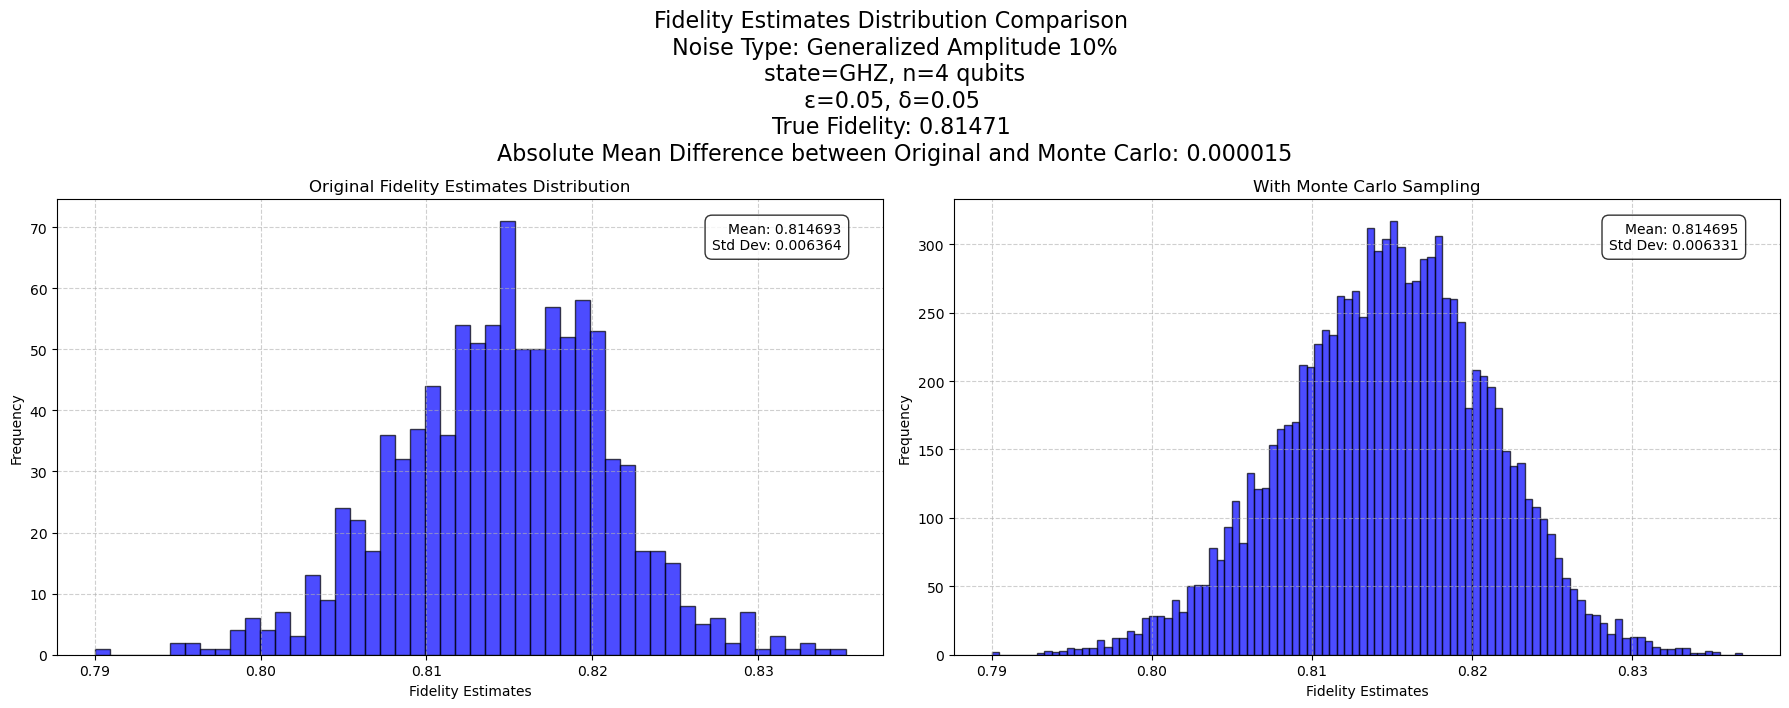


Distribution of Total Copies (m) used in the simulation:


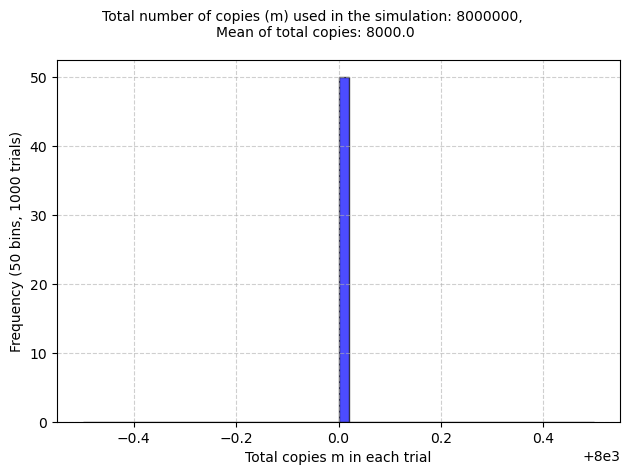

In [48]:
print("\n" + "="*68)
print(f"state={state_str}, n={n_qubits} qubits, ε={epsilon}, δ={delta}, noise type={noise_type_str} {10}%")
print("="*68)

# Making File Directory for saving plots

home_dir = os.path.expanduser('~')
save_dir = os.path.join(home_dir, 'Downloads', 'dfe outputs', state_str, noise_type_str)
os.makedirs(save_dir, exist_ok=True)

# Plotting the Residual errors (Y - F) 

# Calculate the statistics
mean_residuals = np.mean(residuals)
std_residuals = np.std(residuals)
mean_final_residuals = np.mean(final_residuals)
std_final_residuals = np.std(final_residuals)
abs_diff_mean = abs(mean_final_residuals - mean_residuals)

# Format the strings for the annotations
stats_text_original = f"Mean: {mean_residuals:.6f}\nStd Dev: {std_residuals:.6f}"
stats_text_montecarlo = f"Mean: {mean_final_residuals:.6f}\nStd Dev: {std_final_residuals:.6f}"


# Plotting the residual distributions side-by-side
print("\n" + "-"*52)
print("Plotting the Residual errors (Y - F) side-by-side...")
print("-"*52)

plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot histogram for Original Residuals on the first subplot
ax1.hist(residuals, bins=50, density=False, color='blue', alpha=0.7, edgecolor='k')
ax1.set_title(f"Original Residuals Distribution")
ax1.set_xlabel('Signed Residual = Y - F')
ax1.set_ylabel('Frequency')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.text(0.95, 0.95, stats_text_original, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='k'))

# Plot histogram for Monte Carlo sampling residuals on the second subplot
ax2.hist(final_residuals, bins=100, density=False, color='blue', alpha=0.7, edgecolor='k')
ax2.set_title(f"With Monte Carlo Sampling")
ax2.set_xlabel('Signed Residual = Y - F')
ax2.set_ylabel('Frequency')
ax2.grid(True, linestyle='--', alpha=0.6)
# Add text annotation
ax2.text(0.95, 0.95, stats_text_montecarlo, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='k'))


plt.suptitle(f"Residuals Distribution Comparison \n Noise Type: {noise_type_str} {10}% \n state={state_str}, n={n_qubits} qubits \nε={epsilon}, δ={delta} \nAbsolute Mean Difference: {abs_diff_mean:.6f}", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 1])
full_path_1 = os.path.join(save_dir, f'{state_str}_{noise_type_str}_side_by_side_residuals_plot.png')
plt.savefig(full_path_1)
plt.show()

# Plotting the Fidelity Estimates

# Plotting the residual distributions side-by-side
print("\n" + "-"*47)
print("Plotting the Fidelity Estimates side-by-side...")
print("-"*47)

# Calculate the statistics
mean_all_fidelity_ests = np.mean(all_fidelity_ests)
std_all_fidelity_ests = np.std(all_fidelity_ests)
mean_final_fidelity_ests = np.mean(final_fidelity_ests)
std_final_fidelity_ests = np.std(final_fidelity_ests)
true_fidelity = np.ceil(np.mean(all_true_fidelities) * 10 ** 5) / 10 ** 5
abs_diff_mean = abs(mean_final_fidelity_ests - true_fidelity)

# Format the strings for the annotations
stats_text_original = f"Mean: {mean_all_fidelity_ests:.6f}\nStd Dev: {std_all_fidelity_ests:.6f}"
stats_text_montecarlo = f"Mean: {mean_final_fidelity_ests:.6f}\nStd Dev: {std_final_fidelity_ests:.6f}"

# Plotting the Fidelity Estimates side-by-side
plt.style.use('default')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot histogram for Original Fidelity Estimates on the first subplot
ax1.hist(all_fidelity_ests, bins=50, density=False, color='blue', alpha=0.7, edgecolor='k')
ax1.set_title(f"Original Fidelity Estimates Distribution")
ax1.set_xlabel('Fidelity Estimates')
ax1.set_ylabel('Frequency')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.text(0.95, 0.95, stats_text_original, transform=ax1.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='k'))

# Plot histogram for Monte Carlo sampling Fidelity Estimates on the second subplot
ax2.hist(final_fidelity_ests, bins=100, density=False, color='blue', alpha=0.7, edgecolor='k')
ax2.set_title(f"With Monte Carlo Sampling")
ax2.set_xlabel('Fidelity Estimates')
ax2.set_ylabel('Frequency')
ax2.grid(True, linestyle='--', alpha=0.6)
# Add text annotation
ax2.text(0.95, 0.95, stats_text_montecarlo, transform=ax2.transAxes, fontsize=10,
         verticalalignment='top', horizontalalignment='right',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='k'))

plt.suptitle(f"Fidelity Estimates Distribution Comparison \n Noise Type: {noise_type_str} {10}% \n state={state_str}, n={n_qubits} qubits \nε={epsilon}, δ={delta} \nTrue Fidelity: {true_fidelity} \nAbsolute Mean Difference between Original and Monte Carlo: {abs_diff_mean:.6f}", fontsize=16)
plt.tight_layout(rect=[0, 0.1, 1, 1])
full_path_2 = os.path.join(save_dir, f'{state_str}_{noise_type_str}_side_by_side_fidelity_ests.png')
plt.savefig(full_path_2)
plt.show()

# Plotting the distribution of total copies used in the simulation

print("\n" + "="*57)
print("Distribution of Total Copies (m) used in the simulation:")
print("="*57)

# Total copies plot
plt.style.use('default')
plt.hist(all_total_copies, bins=50, density=True, color='blue', alpha=0.7, edgecolor='k')
plt.xlabel('Total copies m in each trial')
plt.ylabel('Frequency (50 bins, {} trials)'.format(1000))
plt.grid(True, linestyle='--', alpha=0.6)
plt.suptitle((f"Total number of copies (m) used in the simulation: {np.sum(all_total_copies)}, \nMean of total copies: {np.mean(all_total_copies)}"), fontsize=10)
plt.tight_layout()
full_path_3 = os.path.join(save_dir, f'{state_str}_{noise_type_str}_total_copies.png')
plt.savefig(full_path_3)
plt.show()

# To Run the Protocol for Different Values of Gamma

In [33]:
# Define the range of gamma values to test
gamma_values = np.arange(0.1, 0.85, 0.05)
num_trials_per_gamma = 1000

# Prepare dictionaries to store the results
results_by_gamma = {
    'residuals': {}
}

print("\n" + "="*20)
print("STARTING SIMULATION")
print("="*20)

all_true_fidelities_per_gamma = []
residuals_per_gamma = {}
mean_of_fidelity_distribution_per_gamma = []

for current_gamma in tqdm(gamma_values, desc="Gamma Value Sweep"):

    residuals, all_fidelity_ests, all_true_fidelities, all_total_copies = run_simulation_optimized(gamma=current_gamma, p_flip=0, num_trials=num_trials_per_gamma)

    results_by_gamma['residuals'][round(current_gamma, 2)] = residuals
    
    all_true_fidelities_per_gamma.append(np.mean(all_true_fidelities))

    residuals_per_gamma[round(current_gamma, 2)] = residuals

    mean_of_fidelity_distribution_per_gamma.append(np.mean(all_fidelity_ests))

    #print("\n" + "="*80)
    #print(f"state={state_str}, n={n_qubits} qubits, ε={epsilon}, δ={delta}, noise type={noise_type_str, int(current_gamma*100)}%")
    #print("="*80)

    # Plotting the Residual errors (Y - F)
    #plt.style.use('default')
    #plt.hist(residuals, bins=75, density=False, color='blue', alpha=0.7, edgecolor='k')
    #plt.xlabel('Signed Residual = Y - F')
    #plt.ylabel('Probability Density')
    #plt.title(f"state={state_str}, n={n_qubits} qubits, ε={epsilon}, δ={delta}, noise type={noise_type_str, int(current_gamma*100)}%")
    #plt.grid(True, linestyle='--', alpha=0.6)
#
    #plt.tight_layout()
    #plt.show()

print("\nAll simulations complete!")

print("Analyzing and plotting results...")



STARTING SIMULATION


Gamma Value Sweep: 100%|██████████| 15/15 [31:22<00:00, 125.52s/it]


All simulations complete!
Analyzing and plotting results...


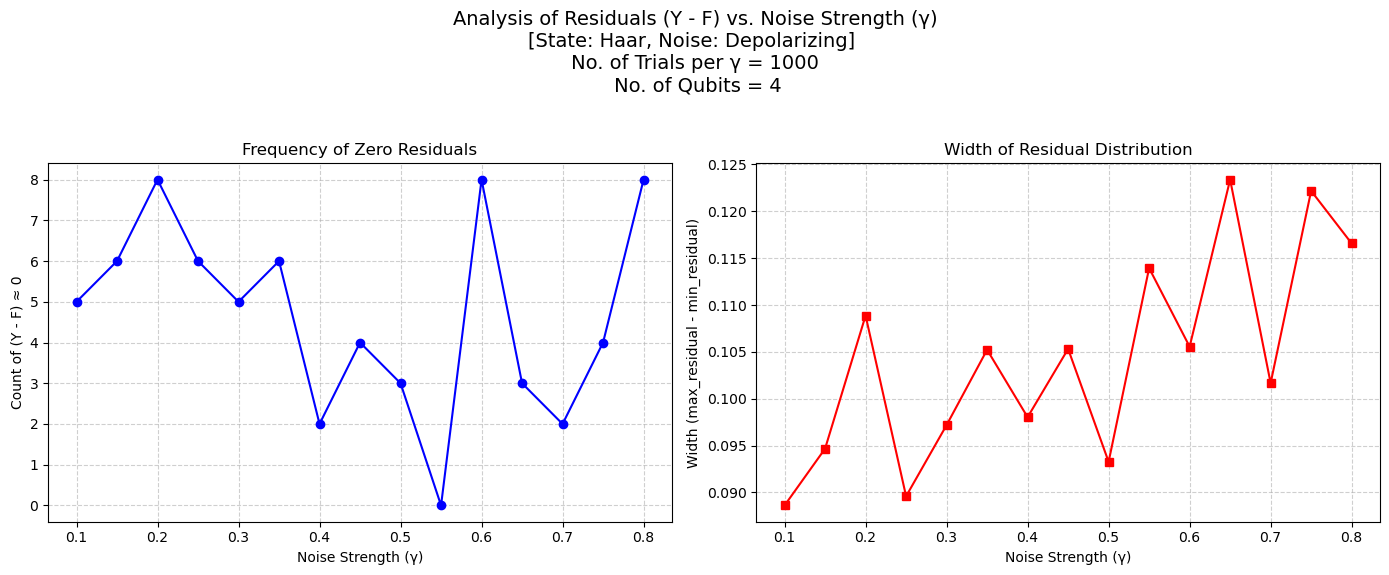

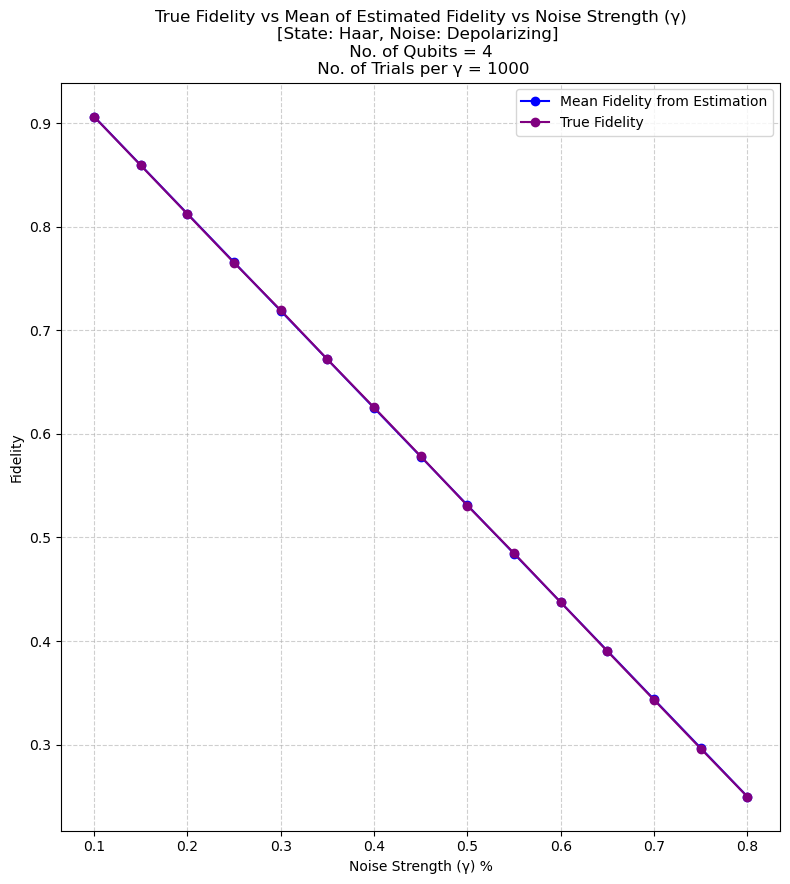

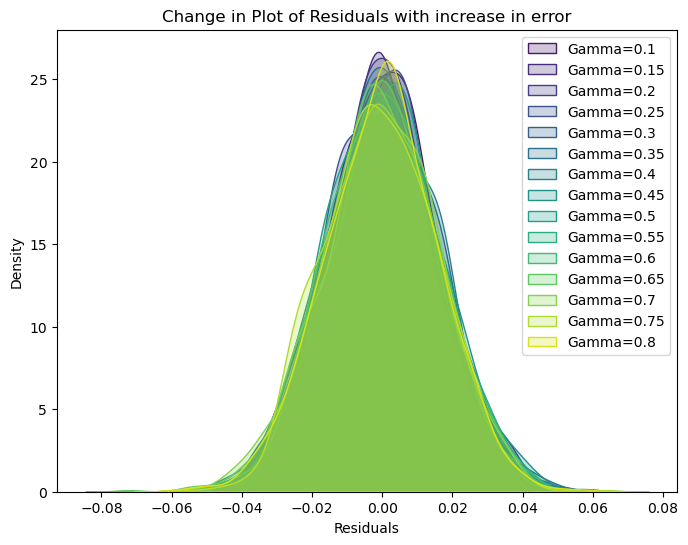

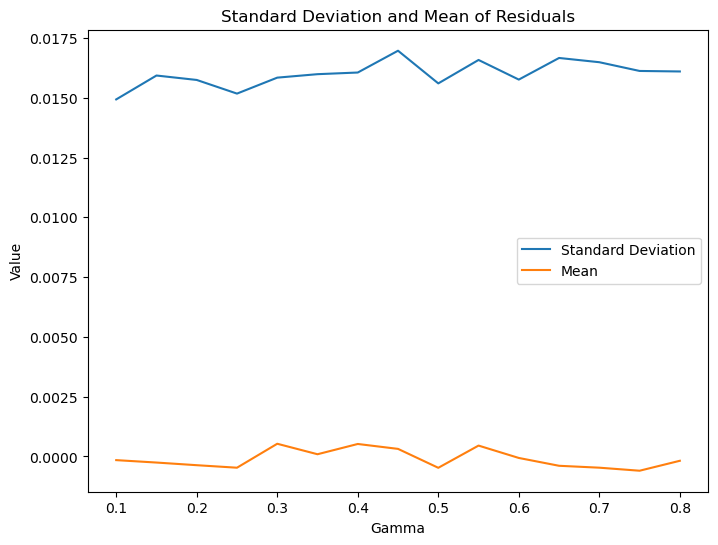

In [ ]:
# A small tolerance to check for "zero" residuals with floating point numbers
zero_tolerance = 1e-4

# Prepare lists for plotting
zero_residual_counts = []
residual_widths = []
sorted_gammas = sorted(results_by_gamma['residuals'].keys())

for gamma in sorted_gammas:
    residuals = np.array(results_by_gamma['residuals'][gamma])
    
    # 1. Count how many residuals are effectively zero
    zero_count = np.sum(np.abs(residuals) < zero_tolerance)
    zero_residual_counts.append(zero_count)
    
    # 2. Calculate the width of the residual distribution
    if len(residuals) > 0:
        width = np.max(residuals) - np.min(residuals)
        residual_widths.append(width)
    else:
        residual_widths.append(0) # No width if no data was produced

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle(f'Analysis of Residuals (Y - F) vs. Noise Strength (γ)\n[State: {state_str}, Noise: {noise_type_str}] \n No. of Trials per γ = {num_trials_per_gamma} \n No. of Qubits = {n_qubits}', fontsize=14)

# Plot 1: Frequency of Zero Residuals
ax1.plot(sorted_gammas, zero_residual_counts, 'o-', color='b')
ax1.set_title('Frequency of Zero Residuals')
ax1.set_xlabel('Noise Strength (γ)')
ax1.set_ylabel('Count of (Y - F) ≈ 0')
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Width of Residual Distribution
ax2.plot(sorted_gammas, residual_widths, 's-', color='r')
ax2.set_title('Width of Residual Distribution')
ax2.set_xlabel('Noise Strength (γ)')
ax2.set_ylabel('Width (max_residual - min_residual)')
ax2.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()

# Plotting the true fidelities and the expected fidelities vs gamma values
plt.style.use('default')
plt.figure(figsize=(8, 6))
plt.plot(sorted(gamma_values), all_true_fidelities_per_gamma, marker='o', linestyle='-', color='blue', label='Mean Fidelity from Estimation')
plt.plot(sorted(gamma_values ), mean_of_fidelity_distribution_per_gamma, marker='o', linestyle='-', color='purple', label='True Fidelity')
#plt.plot(sorted(gamma_values ), closest_expected_fidelity, marker='o', linestyle='-', color='green', label='Closest Expected Fidelity')
plt.title(f'True Fidelity vs Mean of Estimated Fidelity vs Noise Strength (γ)\n[State: {state_str}, Noise: {noise_type_str}] \n No. of Qubits = {n_qubits} \n No. of Trials per γ = {num_trials_per_gamma}')
plt.xlabel('Noise Strength (γ) %')
plt.ylabel('Fidelity')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout(rect=[0, 0.01, 1, 1.5]) 
plt.show()



# KDE Plot
fig, ax = plt.subplots(figsize=(8, 6))
palette = sns.color_palette('viridis', len(residuals_per_gamma))
for i, (gamma, residuals) in enumerate(residuals_per_gamma.items()):
    sns.kdeplot(residuals, shade=True, ax=ax, label=f'Gamma={gamma}', color=palette[i])
    warnings.simplefilter(action='ignore', category=FutureWarning)
ax.set_title('Change in Plot of Residuals with increase in error')
ax.set_xlabel('Residuals')
ax.set_ylabel('Density')
ax.legend()
plt.show()

# Standard Deviation and Mean Plot
fig, ax = plt.subplots(figsize=(8, 6))
std_devs = [np.std(residuals) for residuals in residuals_per_gamma.values()]
means = [np.mean(residuals) for residuals in residuals_per_gamma.values()]
gamma_values = list(residuals_per_gamma.keys())
ax.plot(gamma_values, std_devs, label='Standard Deviation')
ax.plot(gamma_values, means, label='Mean')
ax.set_title('Standard Deviation and Mean of Residuals')
ax.set_xlabel('Gamma')
ax.set_ylabel('Value')
ax.legend()
plt.show()